<a href="https://colab.research.google.com/github/luoterolb/MIT_mod1/blob/main/CE_1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caso de estudio 1.3: *PCA* - Identificando caras

---
<br>

**Recursos adicionales:**

* Guía del caso de estudio
* Artículo original de Matthew A. Turk y Alex P. Pentland: [Face Recognition Using Eigenfaces](http://www.mit.edu/~9.54/fall14/Classes/class10/Turk%20Pentland%20Eigenfaces.pdf)
* Caso de estudio de JHU: [Eigenfaces for Face Detection/Recognition](http://www.vision.jhu.edu/teaching/vision08/Handouts/case_study_pca1.pdf)
* Entradas de blogs:
    * [EigenFaces and A Simple Face Detector with PCA/SVD in Python](https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/)
    * [How to Get Eigenfaces](https://medium.com/@lwj.liuwenjing/how-to-get-eigenfaces-a9caeeba8767) ([source code](https://colab.research.google.com/drive/1T3cSvQZjKhh8s3Dxrb9gPCWhwhcz4Bmo#scrollTo=q2mPsa4M3Jkc)
    * [Eigenfaces: Recovering Humans from Ghosts](https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184)

<br>

---


Configuración del notebook:

Sincronice su cuenta de Google. Para ello, siga el link que aparece en la salida de la siguiente celda una vez ejecutada. Copie el código que le aparece en pantalla e introdúzcalo en la salida de la celda.

Esta celda también le permitirá importar la base de datos que se usará en este caso de estudio.

Una vez vea el mensaje: `¡Google Drive sincronizado y base de datos importada con éxito!` puede continuar ejecutando el resto de celdas.

In [ ]:
from google.colab import auth, drive
auth.authenticate_user()

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import zipfile

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

data_drop = drive.CreateFile({'id':'1Ef3kc82CVbUAqudU1gKs0rxxKC25jdaq'})
data_drop.GetContentFile('training_set.zip')
with zipfile.ZipFile('training_set.zip', 'r') as zip_ref:
    zip_ref.extractall('')

data_drop = drive.CreateFile({'id':'1OfGSJGEzQENEUDL-yGem0fb_zV1og2Lo'})
data_drop.GetContentFile('test_set.zip')
with zipfile.ZipFile('test_set.zip', 'r') as zip_ref:
    zip_ref.extractall('')

print('¡Google Drive sincronizado y base de datos importada con éxito!')

MessageError: ignored

Importar librerías necesarias:

In [ ]:
import numpy as np
from sklearn.preprocessing import normalize
import os

#Visualización
import matplotlib.pyplot as plt
import skimage
from skimage import io, color, transform, exposure


print('\n¡Librerías importadas con éxito!')


¡Librerías importadas con éxito!


# Base de datos

---
<br>

En este ejemplo se utiliza la base de datos pública [LFWcrop](http://conradsanderson.id.au/lfwcrop/), desarrollada por Conrad Sanderson. Esta base de datos es un subconjunto de una base de datos mayor llamada [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (LFW), y que se utiliza mucho en _Computer vision_.

Esta base de datos está compuesta de imágenes de 64x64 píxeles, que contienen caras de personas. Las imágenes se han cortado de modo que la cara ocupe toda la imagen. La versión en escala de grises de todas las imágenes puede encontrarse en [`Data/lfwcrop_grey_faces`](https://drive.google.com/drive/folders/1sdDB6utZeRGOgfF7PZhk6wTj3Qhjv1Fm?usp=sharing). La base de datos cuenta con 13233 imágenes, pero en este ejemplo usaremos 100.

<br>

---


La base de datos contiene más de una imagen para ciertas personas. El conjunto de entrenamiento estará compuesto de 100 (M) imágenes de personas __diferentes__. Pueden explorarse otros tamaños del conjunto de entrenamiento.

In [ ]:
#Número de imágenes en el conjunto de entrenamiento (max 100)
M = 100
print('Tamaño del conjunto de entrenamiento: {} imágenes'.format(M))

#Definir tamaño de las imágenes
irow,icol = (64,64)


#Importar los nombres de las M primeras imágenes del conjunto de entrenamiento
dir_='training_set/'
training_set_filenames = os.listdir(dir_)
training_set_filenames.remove('.DS_Store')

Tamaño del conjunto de entrenamiento: 100 imágenes


Podemos importar las imágenes, "aplanarlas" (transformar una matriz de $N_1xN_2$ píxeles en un vector de $N_1xN_2$ valores de longitud), y almacenarlas en un matriz (`S_raw`).

In [ ]:
S_raw = np.ndarray((irow*icol,M))

for i in range(M):
    #Leer img
    img = io.imread('training_set/{}'.format(training_set_filenames[i]))
    img = color.rgb2gray(img)
    img = transform.resize(img, (irow,icol),anti_aliasing=True)
    #Añadir img a la matriz
    S_raw[:,i]= img.flatten()

print('Dimensiones de S_raw: {}'.format(S_raw.shape))
print('S_raw dtype: {}'.format(S_raw.dtype))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  


Dimensiones de S_raw: (4096, 100)
S_raw dtype: float64


## Funciones auxiliares

Algunas funciones auxiliares para visualizar las imágenes durante el caso de estudio.

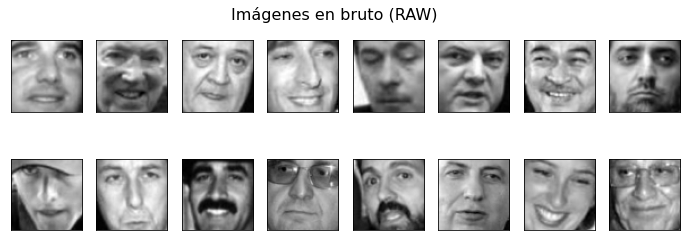

In [ ]:
def plot_images(S,title=''):
    S = S[:,:16].copy()
    fig, axes = plt.subplots(nrows=round(S.shape[1]/8), ncols=8,figsize=(12,4))
    plt.subplots_adjust(wspace = 0.2,hspace = 0.2)
    ax = axes.ravel()
    fig.suptitle(title, fontsize = 16, y=0.95)
    for i in range(S.shape[1]):
        #Mostrar las img
        ax[i].imshow(S[:,i].reshape((irow,icol)), cmap='gray')
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
    plt.show()

plot_images(S_raw,title='Imágenes en bruto (RAW)')

# Preprocesamiento de imágenes


Para poder acondicionar el conjunto de entrenamiento conviene normalizar (hacer que todas las imágenes tengan la misma media y desviación estándar) y centrar cada imagen (restar la imagen media de todo el conjunto a cada imagen).

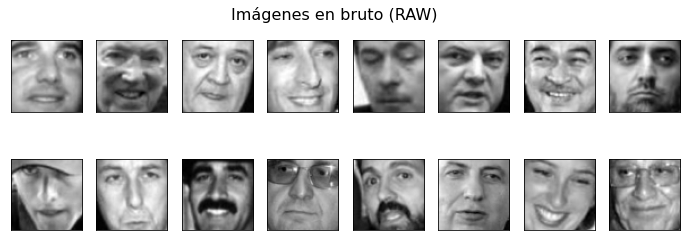

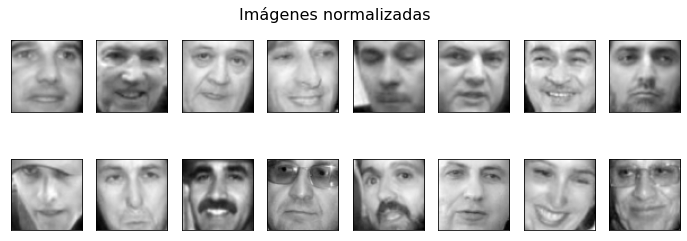

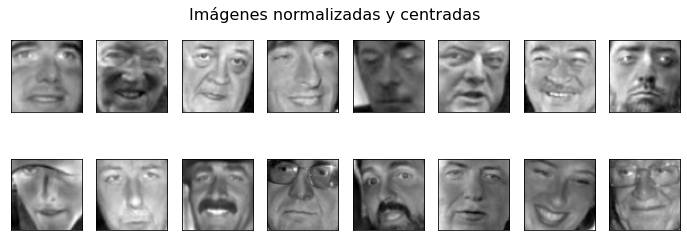

In [ ]:
S_processed = S_raw.copy()
plot_images(S_raw,title='Imágenes en bruto (RAW)')
#Normalización
um = S_processed.mean(axis=1)
ustd = S_processed.std(axis=1)
for i in range(M):
    S_processed[:,i] = (S_processed[:,i] - S_processed[:,i].mean()) * ustd/S_processed[:,i].std() + um

plot_images(S_processed,title='Imágenes normalizadas')

#Centrado
mean_img = S_processed.mean(axis= 1)
for i in range(M):
    S_processed[:,i] = S_processed[:,i] - mean_img

plot_images(S_processed,title = 'Imágenes normalizadas y centradas')


También podemos visualizar la "imagen media":

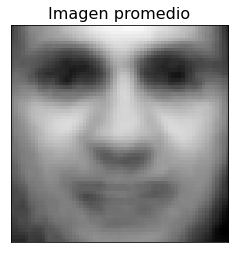

In [ ]:
ax,fig = plt.subplots()
plt.imshow(skimage.img_as_ubyte(mean_img.reshape((irow,icol))), cmap='gray')
plt.title('Imagen promedio',fontsize= 16)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

# Calculando las  "eigencaras" o "caras propias"

Las _eigencaras_ son los vectores propios de la matriz de covarianza del conjunto de entrenamiento.

Sea A nuestro conjunto de caras (aplanadas y centradas restando la media). Entonces la matriz de covarianza $C$ se calcula de la siguiente manera: $C = AA^T$. Sin embargo, esta matriz es muy grande ($N^2xN^2$), y su cálculo puede ser muy costoso a nivel computacional. De modo que puede considerarse la matriz $L = A^TA$, que es mucho más pequeña ($MxM$), y cuyos $M$ vectores propios (y sus correspondientes valores propios) permiten el cálculo de los vectores propios de $C$ asociados con sus $M$ mayores valores propios:


In [ ]:
#Matriz de covarianza C=AA'
#Calculamos L=A'A porque C es demasiado grande y costosa de calcular
print('Calculando L = A\'A...')
A = S_processed.copy()
L = np.matmul(A.T,A)
print('Dimensiones de L: {}\n'.format(L.shape))

#Calculando los vectores propios y valores propios de L
print('Calculando los vectores propios y valores propios de L...')
dd, vv = np.linalg.eig(L)
#vv son los vectores propios de L
#dd son los valores propios de L y C
print('Dimensiones del conjunto de vectores propios vv: {}'.format(vv.shape))
print('||vv_0||= {} (ya está normalizado)\n'.format(np.linalg.norm(vv[:,0])))
#Eliminando los vectores propios con valor propio = 0
print('Eliminando los vectores propios con valor propio = 0 (y sus vectores propios correspondientes)\n')
threshold = 1e-4
n = sum(dd > threshold)
d = np.zeros(n)
v = np.zeros((vv.shape[0],n))
j = 0
for i in range(len(dd)):
    if dd[i] > threshold:
        d[j] = dd[i]
        v[:,j] = vv[:,i]
        j += 1
    else:
        print('Eliminando dd[{}] y vv[{}] (dd[{}]={})'.format(i,i,i,dd[i]))
#Ordenando (ascendente)
v = v[:,np.argsort(d)]
d = np.sort(d)
print('||v_0||= {} (ya está normalizado)\n'.format(np.linalg.norm(v[:,0])))

#Vectores propios de la matriz C
print('Calculating the {} higher eigenvectors and eigenvalues of C = AA\' (covariance matrix)...'.format(n))
u = np.matmul(A,v)
print('Dimensiones de u: {}'.format(u.shape))

#Normalización de C
print('||u_0||= {}\n'.format(np.linalg.norm(u[:,0])))
print('Normalizando los vectores propios de la matriz C...')
u = normalize(u, axis = 0)
print('||u_0||= {}'.format(np.linalg.norm(u[:,0])))


Calculando L = A'A...
Dimensiones de L: (100, 100)

Calculando los vectores propios y valores propios de L...
Dimensiones del conjunto de vectores propios vv: (100, 100)
||vv_0||= 0.9999999999999999 (ya está normalizado)

Eliminando los vectores propios con valor propio = 0 (y sus vectores propios correspondientes)

Eliminando dd[46] y vv[46] (dd[46]=4.263256409723973e-14)
||v_0||= 0.9999999999999999 (ya está normalizado)

Calculating the 99 higher eigenvectors and eigenvalues of C = AA' (covariance matrix)...
Dimensiones de u: (4096, 99)
||u_0||= 2.0502321965823596

Normalizando los vectores propios de la matriz C...
||u_0||= 1.0000000000000002


Una vez tenemos los vectores propios u<sub>i</sub>, tranformándolos de nuevo en imágenes de NxN píxeles podemos obtener las _eigencaras_:

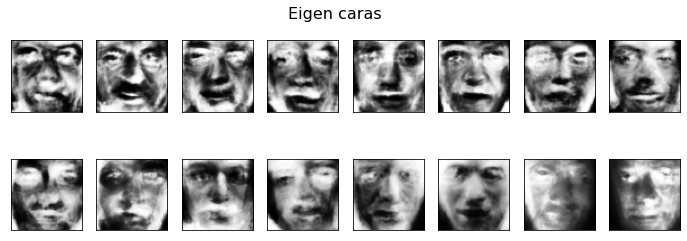

In [ ]:
#Mostrar las eigen caras
eigen_faces = np.ndarray((irow*icol,u.shape[1]))
for i in range(u.shape[1]):
    eigen_faces[:,i] = exposure.equalize_hist(u[:,i],nbins=256)
eigen_faces = skimage.img_as_ubyte(eigen_faces)
plot_images(eigen_faces[:,-16:],title = 'Eigen caras')

# Reconstruyendo y clasificando nuevas caras


Una posible aplicación de las _eigencaras_ es reconstruir imágenes que no están dentro del conjunto de entrenamiento. En este caso se toman 16 imágenes de la base de datos:

Dichas imágenes pueden reconstruirse como combinación linear de las _eigencaras_:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  if sys.path[0] == '':


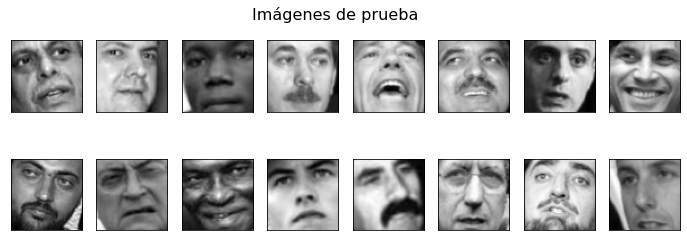

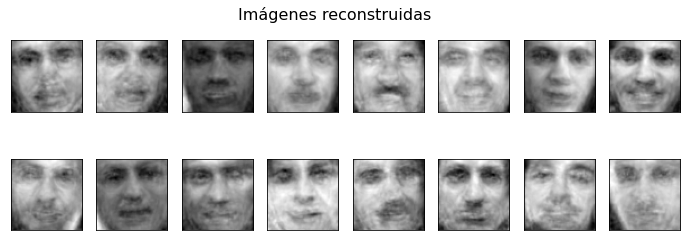

In [ ]:
T=16

#Importar los nombres de las 16 primeras imágenes del conjunto de prueba
dir_='test_set/'
test_set_filenames = os.listdir(dir_)
test_set_filenames.remove('.DS_Store')

S_test_raw = np.ndarray((irow*icol,T))
for i in range(T):
    #Leer img
    img = io.imread('test_set/{}'.format(test_set_filenames[i]))
    img = color.rgb2gray(img)
    img = transform.resize(img, (irow,icol),anti_aliasing=True)
    #Añadir img a la matriz
    S_test_raw[:,i]= img.flatten()

#Normalización
S_test = S_test_raw.copy()
for i in range(T):
    S_test[:,i] = (S_test[:,i] - S_test[:,i].mean()) * ustd/S_test[:,i].std() + um

#Centrado
for i in range(T):
    S_test[:,i] = S_test[:,i] - mean_img

S_reshaped = np.ndarray((irow*icol,T))
for i in range(T):
    S_reshaped[:,i] = mean_img + np.dot(np.dot(u.T,S_test[:,i]),u.T)

#Mostrar las img de entrada y las reconstruidas
plot_images(S_test_raw,title = 'Imágenes de prueba')
plot_images(S_reshaped,title = 'Imágenes reconstruidas')

También puede calcularse distancia (disimilitud) entre las caras del conjunto de test y las del conjunto de entrenamiento:


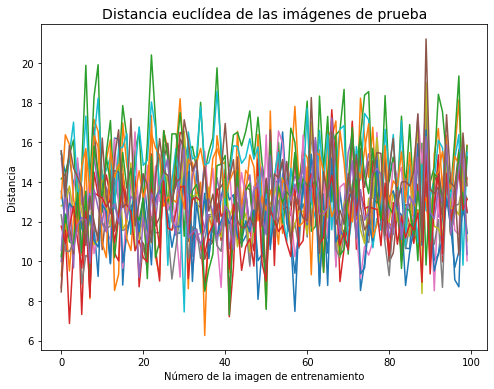

In [ ]:
#Cálculo del peso de las eigencaras en la nueva imagen
weights = np.zeros((u.shape[1],T))
for i in range(T):
    weights[:,i] = np.dot(u.T,S_test[:,i])

omega = np.zeros((u.shape[1],A.shape[1]))
for h in range(A.shape[1]):
    omega[:,h] = np.dot(u.T, A[:,h].T)

#Encontrar la distancia
e = np.zeros((omega.shape[1],T))
for i in range(T):
    for j in range(omega.shape[1]):
        diff_weight = weights[:,i] - omega[:,j]
        e[j,i] = np.linalg.norm(diff_weight)

ax, fig = plt.subplots(figsize=(8,6))
plt.plot(e)
plt.title('Distancia euclídea de las imágenes de prueba',fontsize = 14)
plt.xlabel('Número de la imagen de entrenamiento')
plt.ylabel('Distancia')
plt.show()

hi
